In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

$$
\newcommand{\b}{\exp(-\hbar \omega /kT)}
$$
# Measurement and analysis for the population experiment with 0, 1 states using a Stochastic matrix 

we use the definition of the stochastic matrix here:
https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Signal_Processing_and_Modeling/Discrete_Stochastic_Processes_(Gallager)/03%3A_Finite-State_Markov_Chains/3.01%3A_Introduction_to_Finite-state_Markov_Chains

this means that rows sum to 1, namely:

$$
P_{ij} = \Pr(x_n=j | x_{n-1}=i)
$$

We want to simulate a decay process with probability $p=\exp(-t/T_1)$ into the equilibrium distribution with Boltzmann factor $\b$. 

This has the equilibium distribution
$$
p_0 = \frac{1}{1+\b},\\
p_1 = \frac{\b}{1+\b}
$$

The eigenvalues of the matrix are:
$$
\lambda_0 = 1, \lambda_1 = 1-p-p\b
$$
and the eigenstates are $\pi_0 = (1, -1)$ and $\pi_1 = (p_0, p_1)$.

In [8]:


def generate_markov_samples(p, boltz, runs, steps, initial_state_p):
    """
    p - probability of decay 1 -> 0
    boltz = e^-E/kT
    runs - number of trials
    steps - no. of steps per trial (should be such that (1-p)^steps is small)
    initial_state_p - prob that initial state is 1
    """
    z = boltz   # detailed balance: p(1->0) = boltz * p(0->1)
    x = np.zeros((runs, steps))
    x[:, 0] = np.random.rand(runs) < initial_state_p 
    for j in range(runs):
        s = np.random.rand(steps)
        for i in range(steps - 1):
            if x[j, i] == 0:
                if s[i] < p * z:
                    x[j, i+1] = 1
                else:
                    x[j, i+1] = 0
            else:  # x[j, i] == 1
                if s[i] < p:
                    x[j, i+1]=0
                else:
                    x[j, i+1]=1
    return x


def expected_matrix(p, boltz):
    """
    return the Stochastic matrix (rows sum to 1) of the process
    """
    z = boltz
    return np.array([[1-z*p, p], [z*p, 1-p]]).T

Text(0, 0.5, 'prob.')

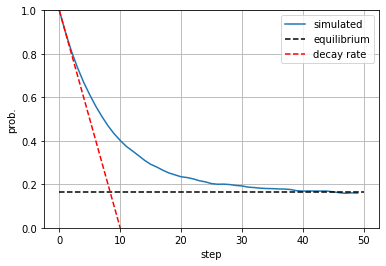

In [14]:
runs_plt = 10000
# generate markov process
p_plt = 0.1
boltz_plt = 0.2  # e^-E/kT
p_0 = boltz_plt / (1 + boltz_plt)

steps_plt = 50

x = generate_markov_samples(p_plt, boltz_plt, runs_plt, steps_plt, 1)
                
plt.plot(x.mean(0), label='simulated')

n_ax = np.arange(steps_plt)
plt.plot([0, steps_plt], [p_0, p_0], 'k--', label='equilibrium')
plt.plot(n_ax, 1 - p_plt * n_ax, 'r--', label='decay rate')
plt.ylim((0,1))
plt.grid('all')
plt.legend()
plt.xlabel('step')
plt.ylabel('prob.')

In [15]:
M = expected_matrix(p_plt, boltz_plt)
w, v = np.linalg.eig(M)
print(w)  # 2nd eigenvalue is 1 - p - b*p

[1.   0.88]


In [16]:
runs_exp = 10
steps_exp = 10000

x = generate_markov_samples(p_plt, boltz_plt, runs_exp, steps_exp, boltz_plt)

# create pairs
x_pairs = np.zeros((runs_exp, steps_exp-1, 2))
for i in range(runs_exp):
    for j in range(steps_exp-1):
        x_pairs[i, j, :] = np.array(x[i, [j, j+1]])
        
# count occurences
n_pair = {}
outcomes = [(0, 0), (0, 1), (1, 0), (1, 1)]
for outcome in outcomes:
    n_pair[outcome] = np.zeros(runs_exp)

n_c = {}

# count occurences - pairs
for i in range(runs_exp):
    for j in range(steps_exp - 1):
        n_pair[tuple(x_pairs[i, j])][i] += 1

# count occurences
for outcome in [0, 1]:
    n_c[outcome] = np.count_nonzero(x[:, 1:]==outcome, axis=1)

In [17]:
p_01 = np.mean(n_pair[(0, 1)] / n_c[1])
p_10 = np.mean(n_pair[(1, 0)] / n_c[0])
p_00 = np.mean(n_pair[(0, 0)] / n_c[0])
p_11 = np.mean(n_pair[(1, 1)] / n_c[1])

M_exp = np.array([[p_00, p_10], [p_01, p_11]])

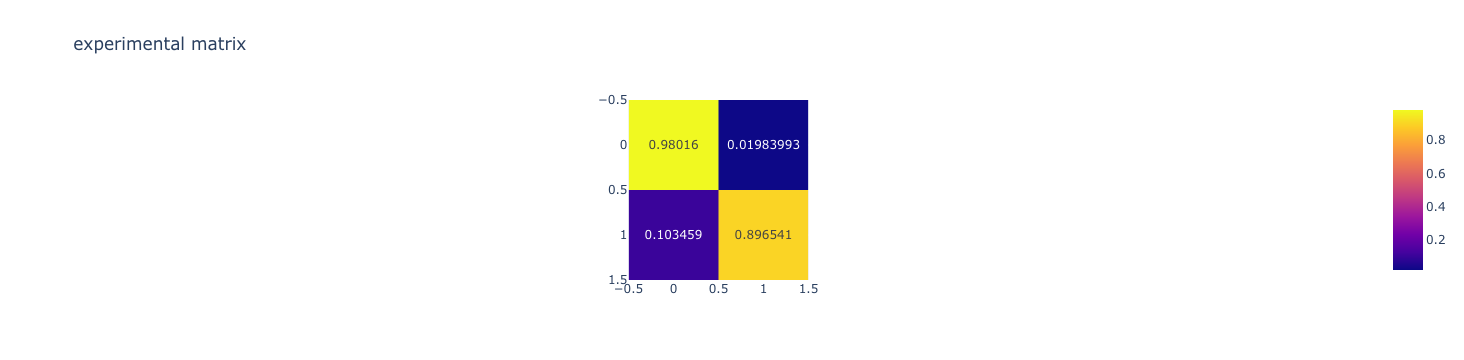

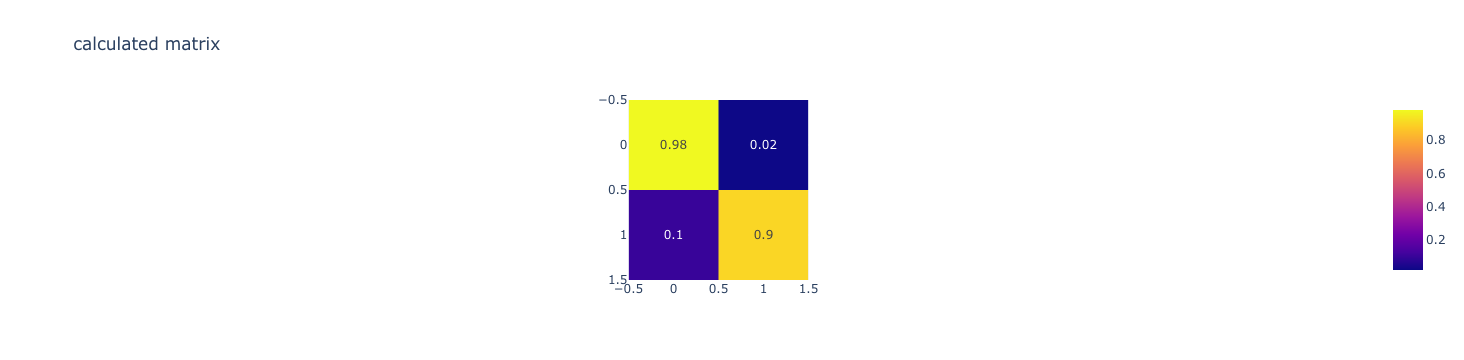

In [18]:
plt_M = px.imshow(M_exp, text_auto=True, title='experimental matrix')
plt_M_exp = px.imshow(M, text_auto=True, title='calculated matrix')
plt_M.show()
plt_M_exp.show()